In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [202]:
def parallel_trend_assumption(panel):
    def plot_trend(pre_panel, post_panel,c = "red", annotation=""):
        m_pre = sm.OLS(pre_panel[["Y"]], pre_panel[["year","intercept"]]).fit()
        m_post = sm.OLS(post_panel[["Y"]], post_panel[["year", "intercept"]]).fit()
        
        x_pre_values = sorted(pre_panel["year"].unique())
        x_pre_values += [max(x_pre_values)+1]
        y_pre_values = [m_pre.params["intercept"] +(m_pre.params["year"]*x) for x in x_pre_values]
        
        x_post_values = sorted(post_panel["year"].unique())
        y_post_values = [m_post.params["intercept"] +(m_post.params["year"]*x) for x in x_post_values]
        
        plt.plot(x_pre_values+x_post_values, y_pre_values+y_post_values, c=c, label = annotation)
                
    pre_treatment = panel.loc[(panel.treated ==1) & (panel.post==0)].reset_index(drop=True)
    post_treatment = panel.loc[(panel.treated ==1) & (panel.post==1)].reset_index(drop=True)
    
    pre_control = panel.loc[(panel.treated ==0) & (panel.post==0)].reset_index(drop=True)
    post_control = panel.loc[(panel.treated ==0) & (panel.post==1)].reset_index(drop=True)
    
    plt.style.use("seaborn-whitegrid")
    fig = plt.figure(figsize=(25,8))
    plt.axvline(post_treatment["year"].min(), ls = "-.", c="crimson")
    
    plot_trend(pre_treatment,post_treatment, c = "navy", annotation = "Treatment Group")
    plot_trend(pre_control, post_control, c="green", annotation = "Control Group")
    plt.legend(loc=2, prop={'size': 15})
    plt.xlabel("Year", size  = "x-large")
    plt.ylabel("Outcome", size  = "x-large")


In [203]:
control_group = pd.read_csv("../data/MSCI/panel/control_firms_esg_rating_panel.csv")
treatment_group = pd.read_csv("../data/MSCI/panel/treatment_firms_esg_rating_panel.csv")
combined = pd.concat([control_group, treatment_group], axis=0)

Text(0,0.5,'No. of Companies')

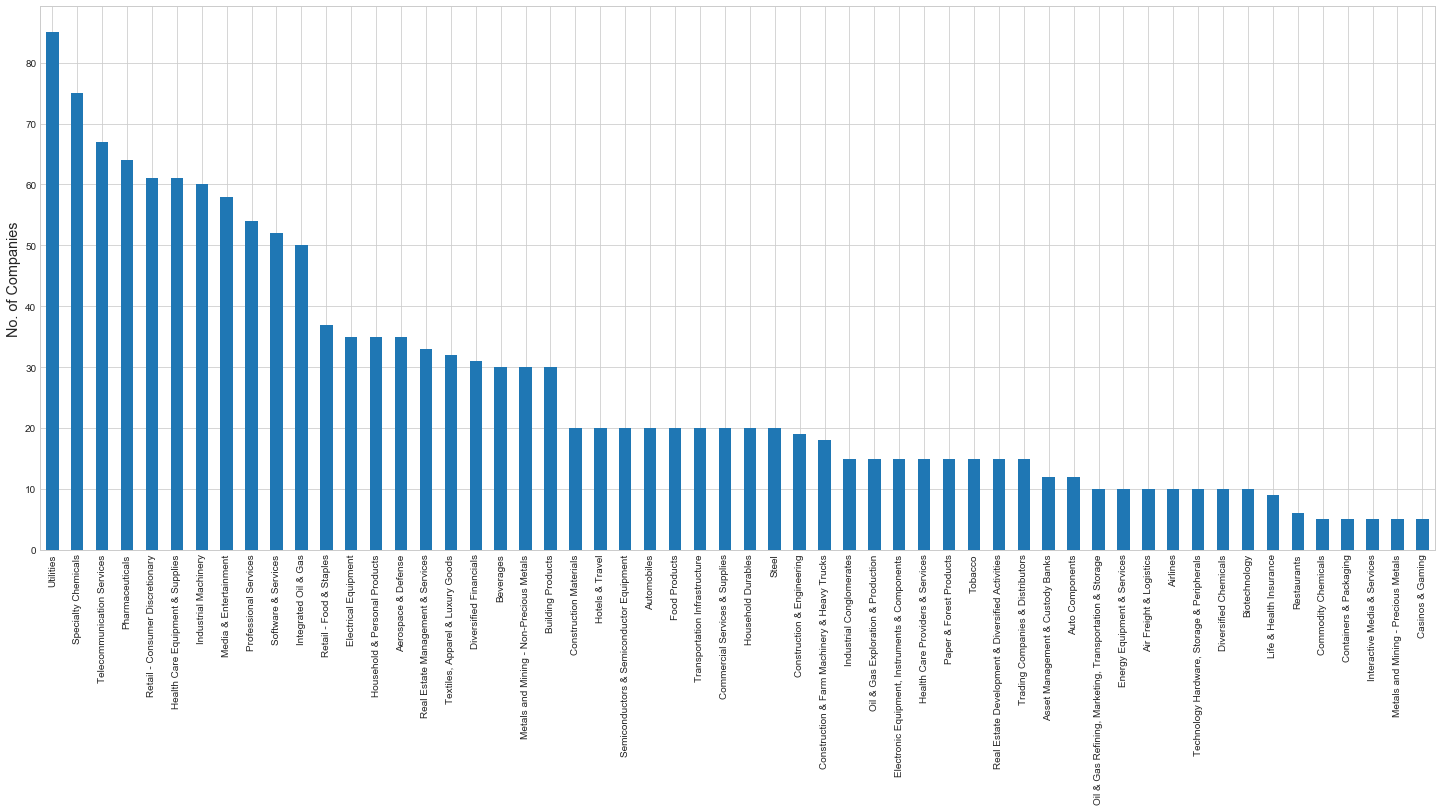

In [204]:
combined.industry.value_counts().plot.bar(figsize=(25,10))
plt.ylabel("No. of Companies", size  = "x-large")

# RDD Analysis

In [205]:
panel = pd.read_csv("../data/MSCI/panel/treatment_firms_esg_rating_panel.csv")

In [206]:
month_index = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May": 5, "Jun":6, "Jul":7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov":11, "Dec":12}
date_to_index = lambda x: month_index[x.split("-")[0]] + ((int(x.split("-")[1])-15) *12)
panel["date_index"] = panel["date"].apply(date_to_index)


esg_ratings = {'A':4, 'AA':5, 'BBB':3, 'BB':2, 'AAA':6, 'B':1, 'CCC':0}
esg_rating_to_numeric = lambda x: esg_ratings[x]
panel["y"] = panel["esg_rating"].apply(esg_rating_to_numeric)

In [207]:
cutoff = 24

panel["post_cutoff"] = (panel["date_index"]>cutoff).astype(int)
panel["running_variable"] = panel["date_index"] - cutoff
panel["intercept"] = 1

In [208]:
model = sm.OLS(panel[["y"]], panel[["intercept","post_cutoff","running_variable"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.516
Date:                Tue, 07 Apr 2020   Prob (F-statistic):             0.0111
Time:                        23:23:46   Log-Likelihood:                -2333.8
No. Observations:                1339   AIC:                             4674.
Df Residuals:                    1336   BIC:                             4689.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            4.1252      0.076     54.048      0.000       3.976       4.275
post_cutoff          0.0417      0.139      0.301      0.764      -0.231       0.314
running_variable     0.0057      0.004      1.480      0.139      -0.002       0.013
==============================================================================
Omnibus:                       75.536   Durbin-Watson:                   0.462
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.647
Skew:                          -0.624   Prob(JB):                     9.28e-20
Kurtosis:                       2.880   Cond. No.                         79.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [209]:
c_panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns=["country"], drop_first=True)

model = sm.OLS(c_panel[["y"]], c_panel[["intercept","post_cutoff","running_variable"]+[c for c in c_panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     11.45
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           5.13e-37
Time:                        23:23:46   Log-Likelihood:                -2221.1
No. Observations:                1339   AIC:                             4488.
Df Residuals:                    1316   BIC:                             4608.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                       4.7771      0.317     15.046      0.000       4.154       5.400
post_cutoff                    -0.0069      0.129     -0.053      0.958      -0.260       0.246
running_variable                0.0077      0.004      2.173      0.030       0.001       0.015
d__Cyprus                      -1.6101      0.653     -2.467      0.014      -2.890      -0.330
d__Denmark                      0.2041      0.353      0.578      0.563      -0.488       0.897
d__Finland                     -0.1443      0.365     -0.395      0.693      -0.861       0.572
d__France                      -0.3864      0.374     -1.032      0.302      -1.121       0.348
d__Germany                     -0.9131      0.323     -2.827      0.005      -1.547      -0.279
d__Hungary                     -1.3364      0.511     -2.615      0.009      -2.339      -0.334
d__Ireland                     -0.7195      0.352     -2.042      0.041      -1.411      -0.028
d__Isle of Man                 -1.8984      0.652     -2.910      0.004      -3.178      -0.619
d__Italy                       -1.4770      0.364     -4.057      0.000      -2.191      -0.763
d__Luxembourg                  -3.2518      0.511     -6.363      0.000      -4.254      -2.249
d__Netherlands                 -0.6981      0.338     -2.064      0.039      -1.362      -0.034
d__Norway                       0.0772      0.379      0.204      0.839      -0.667       0.821
d__Portugal                     0.8559      0.511      1.675      0.094      -0.147       1.859
d__Russia                      -4.4585      0.576     -7.743      0.000      -5.588      -3.329
d__Spain                       -0.3090      0.352     -0.877      0.381      -1.000       0.382
d__Sweden                      -0.1990      0.334     -0.596      0.552      -0.854       0.456
d__Switzerland                 -0.8227      0.330     -2.492      0.013      -1.470      -0.175
d__Turkey                      -1.8503      0.652     -2.836      0.005      -3.130      -0.570
d__United Kingdom              -0.5901      0.318     -1.854      0.064      -1.215       0.034
d__United States of America    -2.4536      0.652     -3.760      0.000      -3.734      -1.174
==============================================================================
Omnibus:                       68.814   Durbin-Watson:                   0.496
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.569
Skew:                          -0.591   Prob(JB):                     8.69e-18
Kurtosis:                       3.103   Cond. No.                         818.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [210]:
c_panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns=["industry"], drop_first=True)

model = sm.OLS(c_panel[["y"]], c_panel[["intercept","post_cutoff","running_variable"]+[c for c in c_panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     6.964
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           2.77e-44
Time:                        23:23:46   Log-Likelihood:                -2157.6
No. Observations:                1339   AIC:                             4431.
Df Residuals:                    1281   BIC:                             4733.
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
intercept                                                      3.6638      0.232     15.806      0.000       3.209       4.119
post_cutoff                                                   -0.0191      0.127     -0.150      0.881      -0.268       0.230
running_variable                                               0.0076      0.003      2.186      0.029       0.001       0.014
d__Air Freight & Logistics                                     1.1919      0.453      2.633      0.009       0.304       2.080
d__Airlines                                                    0.7464      0.453      1.649      0.099      -0.141       1.634
d__Asset Management & Custody Banks                           -1.5944      0.453     -3.521      0.000      -2.483      -0.706
d__Auto Components                                            -0.3439      0.424     -0.812      0.417      -1.175       0.487
d__Automobiles                                                -1.1328      0.392     -2.888      0.004      -1.902      -0.363
d__Beverages                                                   1.3311      0.336      3.964      0.000       0.672       1.990
d__Biotechnology                                              -0.7272      0.599     -1.215      0.225      -1.902       0.447
d__Building Products                                           1.1183      0.336      3.324      0.001       0.458       1.778
d__Casinos & Gaming                                           -0.7738      0.599     -1.292      0.196      -1.949       0.401
d__Commercial Services & Supplies                             -0.5980      0.358     -1.669      0.095      -1.301       0.105
d__Commodity Chemicals                                        -1.9226      0.599     -3.212      0.001      -3.097      -0.748
d__Construction & Engineering                                  1.2377      0.364      3.404      0.001       0.524       1.951
d__Construction & Farm Machinery & Heavy Trucks                0.5807      0.412      1.410      0.159      -0.227       1.388
d__Construction Materials                                      0.7533      0.358      2.103      0.036       0.051       1.456
d__Containers & Packaging                                     -0.3211      0.599     -0.536      0.592      -1.496       0.853
d__Diversified Chemicals                                       0.2926      0.453      0.646      0.518      -0.595       1.181
d__Diversified Financials                                      0.2868      0.336      0.853      0.394      -0.372       0.946
d__Electrical Equipment                                        0.4317      0.320      1.347      0.178      -0.197       1.060
d__Electronic Equipment, Instrument

In [211]:
c_panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns=["country","industry"], drop_first=True)

model = sm.OLS(c_panel[["y"]], c_panel[["intercept","post_cutoff","running_variable"]+[c for c in c_panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     9.229
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.15e-76
Time:                        23:23:46   Log-Likelihood:                -2045.7
No. Observations:                1339   AIC:                             4243.
Df Residuals:                    1263   BIC:                             4639.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
intercept                                                      4.6324      0.377     12.285      0.000       3.893       5.372
post_cutoff                                                   -0.0121      0.118     -0.103      0.918      -0.243       0.219
running_variable                                               0.0078      0.003      2.398      0.017       0.001       0.014
d__Cyprus                                                     -0.7312      0.318     -2.302      0.022      -1.354      -0.108
d__Denmark                                                     0.0119      0.348      0.034      0.973      -0.670       0.694
d__Finland                                                    -0.6286      0.366     -1.718      0.086      -1.346       0.089
d__France                                                     -0.5679      0.364     -1.561      0.119      -1.281       0.146
d__Germany                                                    -0.9735      0.317     -3.071      0.002      -1.595      -0.352
d__Hungary                                                    -1.4035      0.479     -2.932      0.003      -2.343      -0.464
d__Ireland                                                    -1.2516      0.362     -3.458      0.001      -1.962      -0.541
d__Isle of Man                                                -0.8750      0.317     -2.756      0.006      -1.498      -0.252
d__Italy                                                      -1.6687      0.357     -4.680      0.000      -2.368      -0.969
d__Luxembourg                                                 -2.9812      0.476     -6.259      0.000      -3.916      -2.047
d__Netherlands                                                -1.1652      0.333     -3.501      0.000      -1.818      -0.512
d__Norway                                                     -0.0238      0.370     -0.064      0.949      -0.751       0.703
d__Portugal                                                    0.3789      0.475      0.798      0.425      -0.553       1.310
d__Russia                                                     -4.3993      0.542     -8.115      0.000      -5.463      -3.336
d__Spain                                                      -0.6002      0.348     -1.727      0.084      -1.282       0.082
d__Sweden                                                     -0.1534      0.329     -0.466      0.641      -0.799       0.492
d__Switzerland                                                -0.9839      0.326     -3.020      0.003      -1.623      -0.345
d__Turkey                                                     -2.1594      0.672     -3.213      0.001      -3.478      -0.841
d__United Kingdom                  

In [212]:
panel.to_csv("../data/MSCI/panel/RDD_panel.csv", index = False)

# Diff-in-Diffs Analysis

In [213]:
control_group = pd.read_csv("../data/MSCI/panel/control_firms_esg_rating_panel.csv")
treatment_group = pd.read_csv("../data/MSCI/panel/treatment_firms_esg_rating_panel.csv")

In [214]:
treatment_group["treated"] = 1
control_group["treated"] = 0

panel = pd.concat([treatment_group, control_group]).reset_index(drop=True)
panel["year"] = panel["date"].apply(lambda x: int("20"+x.split("-")[1]))

month_index = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May": 5, "Jun":6, "Jul":7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov":11, "Dec":12}
date_to_index = lambda x: month_index[x.split("-")[0]] + ((int(x.split("-")[1])-15) *12)
panel["date_index"] = panel["date"].apply(date_to_index)


esg_ratings = {'A':4, 'AA':5, 'BBB':3, 'BB':2, 'AAA':6, 'B':1, 'CCC':0}
esg_rating_to_numeric = lambda x: esg_ratings[x]
panel["Y"] = panel["esg_rating"].apply(esg_rating_to_numeric)
panel["y"] = panel["esg_rating"].apply(esg_rating_to_numeric)

In [215]:
panel["post"] = (panel["date_index"]>24).astype(int)
panel["post_treated"] = panel["post"] * panel["treated"]

panel["intercept"] = 1

panel.to_csv("../data/MSCI/panel/DID_panel.csv", index = False)

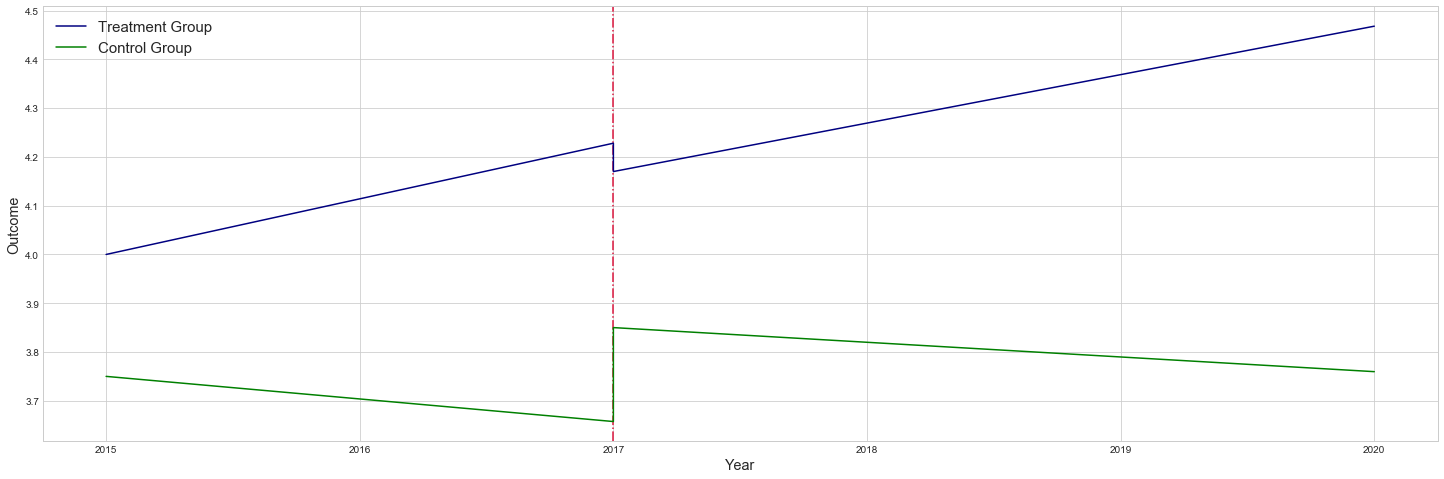

In [216]:
parallel_trend_assumption(panel)

In [217]:
model = sm.OLS(panel[["y"]], panel[["intercept","treated","post","post_treated"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.222
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           0.000338
Time:                        23:23:48   Log-Likelihood:                -2603.3
No. Observations:                1486   AIC:                             5215.
Df Residuals:                    1482   BIC:                             5236.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        3.7209      0.213     17.466      0.000       3.303       4.139
treated          0.3459      0.223      1.551      0.121      -0.092       0.783
post             0.0964      0.253      0.381      0.704      -0.400       0.593
post_treated     0.1132      0.266      0.426      0.670      -0.408       0.635
==============================================================================
Omnibus:                       78.646   Durbin-Watson:                   0.486
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.453
Skew:                          -0.601   Prob(JB):                     2.28e-20
Kurtosis:                       2.877   Cond. No.                         21.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [218]:
d_panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns=["country"], drop_first=True)
model = sm.OLS(d_panel[["y"]], d_panel[["intercept","treated","post","post_treated"]+[c for c in d_panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     11.59
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.14e-43
Time:                        23:23:48   Log-Likelihood:                -2473.1
No. Observations:                1486   AIC:                             5000.
Df Residuals:                    1459   BIC:                             5143.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                       3.7406      0.607      6.163      0.000       2.550       4.931
treated                         0.2772      0.213      1.301      0.193      -0.141       0.695
post                            0.3242      0.236      1.374      0.170      -0.139       0.787
post_treated                   -0.0969      0.247     -0.391      0.696      -0.582       0.389
d__Austria                      0.6906      0.669      1.032      0.302      -0.622       2.003
d__Cyprus                      -0.9543      0.826     -1.155      0.248      -2.575       0.667
d__Denmark                      0.8188      0.611      1.340      0.181      -0.380       2.018
d__Finland                      0.5245      0.622      0.843      0.399      -0.696       1.745
d__France                       0.2859      0.628      0.456      0.649      -0.945       1.517
d__Germany                     -0.3390      0.596     -0.569      0.569      -1.508       0.830
d__Hungary                     -0.6543      0.719     -0.910      0.363      -2.064       0.755
d__Ireland                     -0.0374      0.608     -0.062      0.951      -1.229       1.154
d__Isle of Man                 -1.1997      0.826     -1.452      0.147      -2.821       0.421
d__Italy                       -0.8253      0.616     -1.339      0.181      -2.034       0.383
d__Luxembourg                  -1.3962      0.623     -2.241      0.025      -2.619      -0.174
d__Netherlands                 -0.1313      0.597     -0.220      0.826      -1.303       1.041
d__Norway                       0.6674      0.623      1.072      0.284      -0.554       1.889
d__Poland                      -1.7315      0.943     -1.836      0.067      -3.582       0.118
d__Portugal                     1.6553      0.649      2.550      0.011       0.382       2.929
d__Russia                      -3.7517      0.767     -4.894      0.000      -5.255      -2.248
d__Spain                        0.3677      0.615      0.598      0.550      -0.838       1.573
d__Sweden                       0.5068      0.601      0.843      0.399      -0.672       1.686
d__Switzerland                 -0.1409      0.602     -0.234      0.815      -1.321       1.039
d__Taiwan                      -0.4000      0.816     -0.490      0.624      -2.000       1.200
d__Turkey                      -1.1543      0.826     -1.397      0.163      -2.775       0.467
d__United Kingdom               0.1461      0.594      0.246      0.806      -1.019       1.311
d__United States of America    -1.6999      0.710     -2.396      0.017      -3.092      -0.308
==============================================================================
Omnibus:                       68.079   Durbin-Watson:                   0.511
Prob(Omnibus):                  0.000   Jarqu

In [219]:
d_panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns=["industry"], drop_first=True)
model = sm.OLS(d_panel[["y"]], d_panel[["intercept","treated","post","post_treated"]+[c for c in d_panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     8.097
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           3.76e-55
Time:                        23:23:49   Log-Likelihood:                -2401.2
No. Observations:                1486   AIC:                             4920.
Df Residuals:                    1427   BIC:                             5233.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
intercept                                                      3.2144      0.281     11.449      0.000       2.664       3.765
treated                                                        0.4115      0.204      2.017      0.044       0.011       0.812
post                                                           0.1286      0.227      0.567      0.571      -0.316       0.573
post_treated                                                   0.0806      0.238      0.339      0.735      -0.386       0.547
d__Air Freight & Logistics                                     1.1486      0.446      2.576      0.010       0.274       2.023
d__Airlines                                                    0.7277      0.446      1.632      0.103      -0.147       1.602
d__Asset Management & Custody Banks                           -1.7667      0.416     -4.247      0.000      -2.583      -0.951
d__Auto Components                                            -0.3835      0.416     -0.921      0.357      -1.200       0.433
d__Automobiles                                                -1.7074      0.349     -4.897      0.000      -2.391      -1.023
d__Beverages                                                   1.5252      0.309      4.933      0.000       0.919       2.132
d__Biotechnology                                              -0.0215      0.448     -0.048      0.962      -0.899       0.857
d__Building Products                                           1.1554      0.310      3.731      0.000       0.548       1.763
d__Casinos & Gaming                                           -0.7932      0.594     -1.334      0.182      -1.959       0.373
d__Commercial Services & Supplies                             -0.6619      0.349     -1.898      0.058      -1.346       0.022
d__Commodity Chemicals                                        -1.9514      0.594     -3.283      0.001      -3.117      -0.786
d__Construction & Engineering                                  1.1894      0.355      3.355      0.001       0.494       1.885
d__Construction & Farm Machinery & Heavy Trucks                0.5846      0.361      1.620      0.105      -0.123       1.292
d__Construction Materials                                      0.6986      0.349      2.003      0.045       0.015       1.383
d__Containers & Packaging                                     -0.3514      0.594     -0.591      0.554      -1.517       0.814
d__Diversified Chemicals                                       0.2486      0.446      0.558      0.577      -0.626       1.123
d__Diversified Financials                                      0.4192      0.307      1.367      0.172      -0.182       1.021
d__Electrical Equipment            

In [220]:
d_panel = pd.get_dummies(panel,prefix="d_", prefix_sep='_',columns=["country","industry"], drop_first=True)
model = sm.OLS(d_panel[["y"]], d_panel[["intercept","treated","post","post_treated"]+[c for c in d_panel.columns if "d_" in c]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     10.63
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           1.45e-95
Time:                        23:23:49   Log-Likelihood:                -2264.6
No. Observations:                1486   AIC:                             4689.
Df Residuals:                    1406   BIC:                             5114.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
intercept                                                      3.5448      0.596      5.943      0.000       2.375       4.715
treated                                                        0.2577      0.195      1.320      0.187      -0.125       0.641
post                                                           0.3003      0.210      1.429      0.153      -0.112       0.713
post_treated                                                  -0.0818      0.220     -0.371      0.710      -0.514       0.350
d__Austria                                                     0.9202      0.628      1.466      0.143      -0.311       2.151
d__Cyprus                                                     -0.3668      0.390     -0.941      0.347      -1.131       0.398
d__Denmark                                                     0.8742      0.574      1.523      0.128      -0.252       2.000
d__Finland                                                     0.1560      0.592      0.264      0.792      -1.005       1.317
d__France                                                      0.2299      0.582      0.395      0.693      -0.911       1.371
d__Germany                                                    -0.1924      0.557     -0.346      0.730      -1.284       0.899
d__Hungary                                                    -0.6032      0.670     -0.901      0.368      -1.917       0.711
d__Ireland                                                    -0.4325      0.571     -0.757      0.449      -1.553       0.688
d__Isle of Man                                                -0.4886      0.390     -1.254      0.210      -1.253       0.276
d__Italy                                                      -0.9507      0.581     -1.638      0.102      -2.089       0.188
d__Luxembourg                                                 -1.1257      0.582     -1.934      0.053      -2.267       0.016
d__Netherlands                                                -0.4697      0.560     -0.838      0.402      -1.569       0.630
d__Norway                                                      0.5883      0.589      0.999      0.318      -0.567       1.744
d__Poland                                                     -1.7971      0.867     -2.073      0.038      -3.498      -0.096
d__Portugal                                                    1.2811      0.611      2.097      0.036       0.083       2.480
d__Russia                                                     -3.3178      0.734     -4.519      0.000      -4.758      -1.878
d__Spain                                                       0.1738      0.575      0.302      0.762      -0.954       1.301
d__Sweden                          

# Analysis on Most represented or Most notorious sectors

In [221]:
sub_panel = panel.loc[panel.industry == "Professional Services"]
model = sm.OLS(sub_panel[["y"]], sub_panel[["intercept","treated","post","post_treated"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     5.630
Date:                Tue, 07 Apr 2020   Prob (F-statistic):            0.00210
Time:                        23:23:50   Log-Likelihood:                -83.324
No. Observations:                  54   AIC:                             174.6
Df Residuals:                      50   BIC:                             182.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        2.3333      0.679      3.435      0.001       0.969       3.698
treated          1.7436      0.754      2.314      0.025       0.230       3.257
post             1.3810      0.812      1.701      0.095      -0.250       3.012
post_treated    -0.6192      0.900     -0.688      0.495      -2.427       1.189
==============================================================================
Omnibus:                        8.249   Durbin-Watson:                   0.740
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                7.771
Skew:                          -0.911   Prob(JB):                       0.0205
Kurtosis:                       3.363   Cond. No.                         15.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [222]:
sub_panel = panel.loc[panel.industry == "Specialty Chemicals"]
model = sm.OLS(sub_panel[["y"]], sub_panel[["intercept","treated","post","post_treated"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                   0.01208
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.913
Time:                        23:23:51   Log-Likelihood:                -125.45
No. Observations:                  75   AIC:                             254.9
Df Residuals:                      73   BIC:                             259.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        2.2609      0.136     16.601      0.000       1.989       2.532
treated          2.2609      0.136     16.601      0.000       1.989       2.532
post             0.0180      0.164      0.110      0.913      -0.308       0.344
post_treated     0.0180      0.164      0.110      0.913      -0.308       0.344
==============================================================================
Omnibus:                        9.835   Durbin-Watson:                   0.400
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                5.003
Skew:                          -0.423   Prob(JB):                       0.0820
Kurtosis:                       2.058   Cond. No.                     2.35e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.22e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [223]:
sub_panel = panel.loc[panel.industry == "Utilities"]
model = sm.OLS(sub_panel[["y"]], sub_panel[["intercept","treated","post","post_treated"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.028
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.116
Time:                        23:23:51   Log-Likelihood:                -126.61
No. Observations:                  85   AIC:                             261.2
Df Residuals:                      81   BIC:                             271.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        6.0000      0.777      7.718      0.000       4.453       7.547
treated         -1.3103      0.804     -1.630      0.107      -2.909       0.289
post         -4.441e-15      1.004  -4.43e-15      1.000      -1.997       1.997
post_treated     0.2319      1.036      0.224      0.823      -1.829       2.292
==============================================================================
Omnibus:                       32.062   Durbin-Watson:                   0.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.763
Skew:                          -1.476   Prob(JB):                     1.74e-13
Kurtosis:                       5.808   Cond. No.                         24.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [224]:
sub_panel = panel.loc[panel.industry == "Integrated Oil & Gas"]
model = sm.OLS(sub_panel[["y"]], sub_panel[["intercept","treated","post","post_treated"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9426
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.428
Time:                        23:23:52   Log-Likelihood:                -80.675
No. Observations:                  50   AIC:                             169.4
Df Residuals:                      46   BIC:                             177.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        5.0000      0.896      5.583      0.000       3.197       6.803
treated         -0.5882      0.947     -0.621      0.537      -2.494       1.317
post             0.6667      1.156      0.577      0.567      -1.661       2.994
post_treated    -0.5784      1.220     -0.474      0.638      -3.034       1.877
==============================================================================
Omnibus:                        5.794   Durbin-Watson:                   0.289
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                2.969
Skew:                          -0.353   Prob(JB):                        0.227
Kurtosis:                       2.037   Cond. No.                         18.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [225]:
sub_panel = panel.loc[panel.industry == "Metals and Mining - Non-Precious Metals"]
model = sm.OLS(sub_panel[["y"]], sub_panel[["intercept","treated","post","post_treated"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.035
Method:                 Least Squares   F-statistic:                   0.02546
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.874
Time:                        23:23:52   Log-Likelihood:                -46.681
No. Observations:                  30   AIC:                             97.36
Df Residuals:                      28   BIC:                             100.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.7727      0.179      9.905      0.000       1.406       2.139
treated          1.7727      0.179      9.905      0.000       1.406       2.139
post            -0.0359      0.225     -0.160      0.874      -0.497       0.425
post_treated    -0.0359      0.225     -0.160      0.874      -0.497       0.425
==============================================================================
Omnibus:                        3.740   Durbin-Watson:                   0.537
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.014
Skew:                           0.775   Prob(JB):                        0.222
Kurtosis:                       2.910   Cond. No.                     5.40e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.04e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [226]:
sub_panel = panel.loc[panel.industry == "Pharmaceuticals"]
model = sm.OLS(sub_panel[["y"]], sub_panel[["intercept","treated","post","post_treated"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                   0.02596
Date:                Tue, 07 Apr 2020   Prob (F-statistic):              0.873
Time:                        23:23:58   Log-Likelihood:                -104.35
No. Observations:                  64   AIC:                             212.7
Df Residuals:                      62   BIC:                             217.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        1.9250      0.140     13.715      0.000       1.644       2.206
treated          1.9250      0.140     13.715      0.000       1.644       2.206
post            -0.0273      0.169     -0.161      0.873      -0.366       0.311
post_treated    -0.0273      0.169     -0.161      0.873      -0.366       0.311
==============================================================================
Omnibus:                        4.907   Durbin-Watson:                   0.517
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                3.661
Skew:                           0.451   Prob(JB):                        0.160
Kurtosis:                       2.252   Cond. No.                     9.98e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.99e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""